In [15]:
#Estas son las librerias que utilizaremos
import pandas as pd 
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error

In [16]:
#Cargamos los datos
df = pd.read_csv("210603COVID19MEXICO.csv")
df['FECHA_SINTOMAS'] = pd.to_datetime(df['FECHA_SINTOMAS'])
df.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,OTRO_CASO,TOMA_MUESTRA_LAB,RESULTADO_LAB,TOMA_MUESTRA_ANTIGENO,RESULTADO_ANTIGENO,CLASIFICACION_FINAL,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
0,2021-06-03,z482b8,1,12,9,2,9,9,12,1,...,2,2,97,2,97,1,99,México,97,97
1,2021-06-03,z49a69,1,12,23,1,23,23,4,2,...,1,2,97,2,97,2,99,México,97,1
2,2021-06-03,z23d9d,1,12,22,2,24,22,9,1,...,2,2,97,2,97,6,99,México,97,97
3,2021-06-03,z24953,1,12,9,1,9,9,10,1,...,1,1,2,2,97,7,99,México,97,97
4,2021-06-03,zz8e77,1,12,9,2,9,9,2,1,...,2,2,97,2,97,6,99,México,97,97


In [17]:
#Las fechas tienen relación al intervalo del tiempo de la contigencia que queremos obervar.
fecha_inicio  = "2020-12-15"
fecha_termino = "2021-03-15"

In [18]:
def CalculoEnfermos(data,fecha_inicial,fecha_final):  
    
    data['FECHA_SINTOMAS'] = pd.to_datetime(data['FECHA_SINTOMAS'],format='%Y/%m/%d')
    fecha_inicio_menos14 =  pd.to_datetime(fecha_inicial)  - timedelta(14)
    
    fechas = data[(data["FECHA_SINTOMAS"] >= fecha_inicio_menos14) & (data["FECHA_SINTOMAS"] <= fecha_final)]
    Enfermos = fechas[fechas["CLASIFICACION_FINAL"].isin([1,2,3])]
    
    Confirmados = Enfermos.groupby(["FECHA_SINTOMAS"]).size()
    per_enf = pd.DataFrame(data = Confirmados)
    Personas_Enfermas = per_enf.reset_index().rename(columns={0:'Infectados'})
    
    Personas_Enfermas['FECHA_SINTOMAS'] = pd.to_datetime(Personas_Enfermas['FECHA_SINTOMAS'], format='%Y-%m-%d')
    nuevo = Personas_Enfermas.rolling("15D", on="FECHA_SINTOMAS").sum()['Infectados']
    new_df = Personas_Enfermas.assign(infectados = nuevo)
    new = new_df.iloc[14:,:]

    return new

In [19]:
Enfermos = CalculoEnfermos(data = df ,fecha_inicial = fecha_inicio,fecha_final = fecha_termino)
Enfermos

,FECHA_SINTOMAS,Infectados,infectados
14,2020-12-15,12028,161355.0
15,2020-12-16,9973,158455.0
16,2020-12-17,9661,158822.0
17,2020-12-18,11355,160982.0
18,2020-12-19,9523,160935.0
...,...,...,...
100,2021-03-11,3696,76182.0
101,2021-03-12,3904,74543.0
102,2021-03-13,3487,72301.0
103,2021-03-14,3314,70758.0


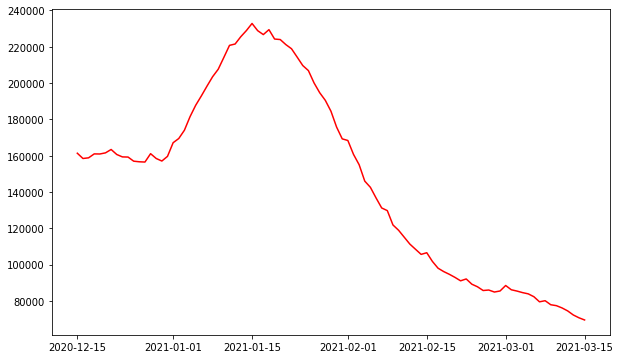

In [20]:
plt.figure(figsize = (10,6))
plt.plot(Enfermos["FECHA_SINTOMAS"],Enfermos["infectados"],'r')

In [21]:
def recuperados(data,fecha_inicial,fecha_final):
    
    data['FECHA_SINTOMAS'] = pd.to_datetime(data['FECHA_SINTOMAS'],format='%Y/%m/%d')
    fecha_inicio14mas  =  pd.to_datetime(fecha_inicial) + timedelta(14)
    fecha_final14menos =  pd.to_datetime(fecha_final) + timedelta(14)
    
    fechas = data[(data["FECHA_SINTOMAS"] >= fecha_inicio14mas) & (data["FECHA_SINTOMAS"] <= fecha_final14menos)]
    df1 = fechas[fechas["CLASIFICACION_FINAL"].isin([1,2,3]) & (fechas["TIPO_PACIENTE"] == 1)]
    
    Confirmados = df1.groupby(["FECHA_SINTOMAS"]).size()
    per_rec = pd.DataFrame(data = Confirmados)
    Personas_recuperadas = per_rec.reset_index().rename(columns={0:'Recuperados'})
    
    Personas_recuperadas['FECHA_SINTOMAS'] = pd.to_datetime(Personas_recuperadas['FECHA_SINTOMAS'], format='%Y-%m-%d')
    nuevo = Personas_recuperadas.rolling("15D", on="FECHA_SINTOMAS").sum()['Recuperados']
    new_df = Personas_recuperadas.assign(recuperados = nuevo)
    
    return new_df

In [22]:
Recuperados = recuperados(data = df ,fecha_inicial = fecha_inicio,fecha_final = fecha_termino)
Recuperados

,FECHA_SINTOMAS,Recuperados,recuperados
0,2020-12-29,8372,8372.0
1,2020-12-30,8777,17149.0
2,2020-12-31,10297,27446.0
3,2021-01-01,13837,41283.0
4,2021-01-02,11645,52928.0
...,...,...,...
86,2021-03-25,2954,49378.0
87,2021-03-26,2590,48837.0
88,2021-03-27,2483,48038.0
89,2021-03-28,2363,47477.0


Text(0.5, 1.0, 'Recuperados')

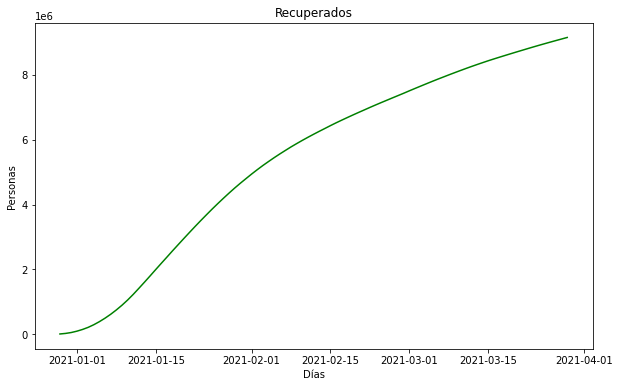

In [23]:
plt.figure(figsize = (10,6))
plt.plot(Recuperados["FECHA_SINTOMAS"],np.cumsum(Recuperados["recuperados"]),color = "green")
plt.xlabel("Días")
plt.ylabel("Personas")
plt.title("Recuperados")

In [24]:
#Funciones que nos ayudaran para calcular los valores del modelo SIR
def SuceptiblesIniciales(poblacion_total,VI_infectados,VI_recuperados):
    return poblacion_total - (VI_infectados + VI_recuperados)

def CalcularBeta(promedio_de_contactos,probabilidad_de_transmicion):
    return promedio_de_contactos*probabilidad_de_transmicion

def CalcularGamma(dias_de_recuperacion):
    return 1.0/dias_de_recuperacion

def deriv_suceptible(beta,suceptible,infectado,poblacion_total):
    return -beta * suceptible *infectado / poblacion_total

def deriv_infectado(beta,suceptible,infectado,poblacion_total,gamma):
    return beta * suceptible * infectado / poblacion_total - gamma*infectado

def deriv_recuperados(infectado,gamma):
    return gamma*infectado

def deriv_helper(VI,tiempo,poblacion_total,beta,gamma):
    suceptible,infectado,recuperado= VI
    dSdt = deriv_suceptible(beta, suceptible, infectado, poblacion_total)
    dIdt = deriv_infectado(beta, suceptible, infectado, poblacion_total, gamma)
    dRdt = deriv_recuperados(infectado, gamma)
    return dSdt, dIdt, dRdt

def plot_sir(tiempo,suceptible,infectado,recuperado):
    fig = plt.figure(figsize = (10,6.5),facecolor = 'w')

    ax = fig.add_subplot(111,axisbelow=True)
    ax.plot(tiempo, suceptible, 'b', alpha=0.5,lw=2, label = "Suceptible")
    ax.plot(tiempo, infectado , 'r', alpha=0.5,lw=2, label = "Infectado ")
    ax.plot(tiempo, recuperado, 'g', alpha=0.5,lw=2, label = "Recuperado")
    ax.plot(tiempo,Enfermos["infectados"], color = 'purple',  alpha=0.5,lw=2, label = "Infectados")
    ax.plot(tiempo,np.cumsum(Recuperados["Recuperados"]),color = 'orange', alpha=0.5,lw=2, label = "Recuperados")

    ax.set_xlabel("Días")
    ax.set_ylabel("Poblacion")

    ax.set_title("Modelo SIR")
    legend = ax.legend()

    plt.grid()
    plt.show()

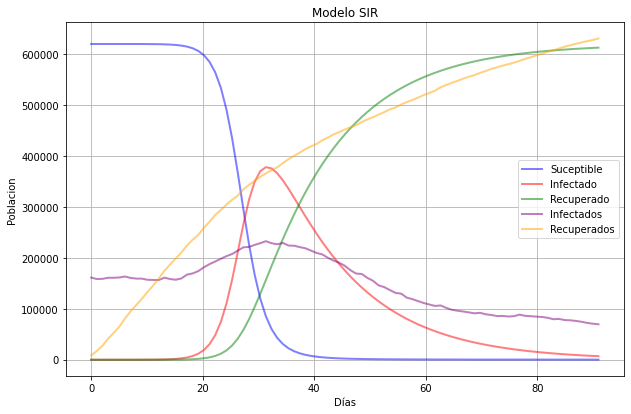

In [25]:
#Proponemos una poblacion 
poblacion_total = 620000
#numero de dias a considerar
dias = len(Recuperados["FECHA_SINTOMAS"])
#definimos VI_infectados,VI_recuperados
VI_infectados = 1
VI_recuperados = 0
#Definimos beta
promedio_de_contactos = 3
probabilidad_de_transmicion = .187
#Definimos gamma
dias_de_recuperacion = 14

""" Calculos """
#valores iniciales para los suceptibles 
VI_suceptibles = SuceptiblesIniciales(poblacion_total, VI_infectados, VI_recuperados)
#beta 
beta = CalcularBeta(promedio_de_contactos, probabilidad_de_transmicion)
#gamma
gamma = CalcularGamma(dias_de_recuperacion)
#tiempo
tiempo = np.linspace(0,dias,dias)
#condiciones iniciales 
VI = (VI_suceptibles,VI_infectados,VI_recuperados)
#integrando el las EDO's
func_integ = odeint(deriv_helper, VI, tiempo, args = (poblacion_total,beta,gamma))
suceptible,infectado,recuperado = func_integ.T
#dibujamos las graficas
plot_sir(tiempo,suceptible,infectado,recuperado)

In [27]:
#Proponemos una poblacion 
poblacion_total = 620000
#numero de dias a considerar
dias = len(Recuperados["FECHA_SINTOMAS"])
#definimos VI_infectados,VI_recuperados
VI_infectados = 1
VI_recuperados = 0
#Definimos gamma
dias_de_recuperacion = 14
#Definimos beta
promedio_de_contactos = 3
probabilidad_de_transmision = np.linspace(0.1,1)

""" Calculos """
#valores iniciales para los suceptibles 
VI_suceptibles = SuceptiblesIniciales(poblacion_total, VI_infectados, VI_recuperados)
#gamma
gamma = CalcularGamma(dias_de_recuperacion)
#tiempo
tiempo = np.linspace(0,dias,dias)
#condiciones iniciales 
VI = (VI_suceptibles,VI_infectados,VI_recuperados)

beta_values = []

for i in probabilidad_de_transmision:
    beta_iter = CalcularBeta(promedio_de_contactos, probabilidad_de_transmision)
    beta_values.append(beta_iter)
    print("la probabilidad de transmicion es {} y el valor de beta es {}".format(i,beta_iter))


la probabilidad de transmicion es 0.1 y el valor de beta es [0.3        0.35510204 0.41020408 0.46530612 0.52040816 0.5755102
 0.63061224 0.68571429 0.74081633 0.79591837 0.85102041 0.90612245
 0.96122449 1.01632653 1.07142857 1.12653061 1.18163265 1.23673469
 1.29183673 1.34693878 1.40204082 1.45714286 1.5122449  1.56734694
 1.62244898 1.67755102 1.73265306 1.7877551  1.84285714 1.89795918
 1.95306122 2.00816327 2.06326531 2.11836735 2.17346939 2.22857143
 2.28367347 2.33877551 2.39387755 2.44897959 2.50408163 2.55918367
 2.61428571 2.66938776 2.7244898  2.77959184 2.83469388 2.88979592
 2.94489796 3.        ]
la probabilidad de transmicion es 0.11836734693877551 y el valor de beta es [0.3        0.35510204 0.41020408 0.46530612 0.52040816 0.5755102
 0.63061224 0.68571429 0.74081633 0.79591837 0.85102041 0.90612245
 0.96122449 1.01632653 1.07142857 1.12653061 1.18163265 1.23673469
 1.29183673 1.34693878 1.40204082 1.45714286 1.5122449  1.56734694
 1.62244898 1.67755102 1.73265306 1.78

In [28]:
Beta_Valores = beta_values[0]

for beta in Beta_Valores:
    func_integ = odeint(deriv_helper, VI, tiempo, args = (poblacion_total,beta,gamma))
    suceptible,infectado,recuperado = func_integ.T
    error_enf = mean_absolute_error(infectado,Enfermos["infectados"])
    print("el valor de beta es {} y el error es {}".format(beta,error_enf))

el valor de beta es 0.30000000000000004 y el error es 135932.4014109882
el valor de beta es 0.35510204081632657 y el error es 118023.66802340958
el valor de beta es 0.4102040816326531 y el error es 102590.72834799685
el valor de beta es 0.4653061224489797 y el error es 91532.25015401962
el valor de beta es 0.5204081632653061 y el error es 86119.54632990419
el valor de beta es 0.5755102040816327 y el error es 85855.27423922249
el valor de beta es 0.6306122448979592 y el error es 88200.53236001352
el valor de beta es 0.6857142857142857 y el error es 91201.53583789789
el valor de beta es 0.7408163265306122 y el error es 94477.76047326505
el valor de beta es 0.7959183673469388 y el error es 97324.9369318978
el valor de beta es 0.8510204081632653 y el error es 100344.29494802587
el valor de beta es 0.9061224489795918 y el error es 102910.72087948603
el valor de beta es 0.9612244897959186 y el error es 104992.15364857636
el valor de beta es 1.016326530612245 y el error es 106669.46532682003


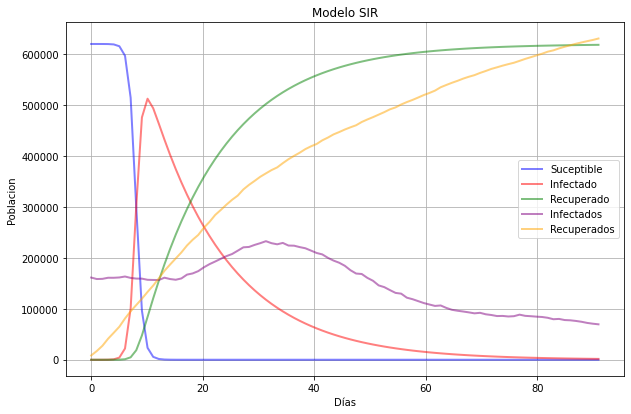

In [30]:
#Proponemos una poblacion 
poblacion_total = 620000
#numero de dias a considerar
dias = len(Recuperados["FECHA_SINTOMAS"])
#definimos VI_infectados,VI_recuperados
VI_infectados = 1
VI_recuperados = 0
#Definimos beta
promedio_de_contactos = 3
probabilidad_de_transmicion = 0.5755102
#Definimos gamma
dias_de_recuperacion = 14

""" Calculos """
#valores iniciales para los suceptibles 
VI_suceptibles = SuceptiblesIniciales(poblacion_total, VI_infectados, VI_recuperados)
#beta 
beta = CalcularBeta(promedio_de_contactos, probabilidad_de_transmicion)
#gamma
gamma = CalcularGamma(dias_de_recuperacion)
#tiempo
tiempo = np.linspace(0,dias,dias)
#condiciones iniciales 
VI = (VI_suceptibles,VI_infectados,VI_recuperados)
#integrando el las EDO's
func_integ = odeint(deriv_helper, VI, tiempo, args = (poblacion_total,beta,gamma))
suceptible,infectado,recuperado = func_integ.T
#dibujamos las graficas
plot_sir(tiempo,suceptible,infectado,recuperado)